# Capstone: Employee Review Monitoring

---

#### 03b: <b>Modeling - LSTM</b>

## Library and data import

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import keras.backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
# Load data
df_modeling = pd.read_csv("../data/train_modeling.csv")

In [3]:
print(df_modeling.shape)
display(df_modeling.head())
print(df_modeling['v_sentiment'].value_counts())

(30099, 2)


,combined_text,v_sentiment
0,Best Company to work for People are smart and ...,1
1,"Moving at the speed of light, burn out is inev...",1
2,Great balance between big-company security and...,1
3,The best place I've worked and also the most d...,1
4,Execellent for engineers Impact driven. Best t...,1


 1    27294
-1     2578
 0      227
Name: v_sentiment, dtype: int64


In [4]:
# Change 'Neutral' class to 'Negative'
df_modeling['v_sentiment'] = df_modeling['v_sentiment'].replace([0],-1)

df_modeling['v_sentiment'].value_counts()

 1    27294
-1     2805
Name: v_sentiment, dtype: int64

In [5]:
# Change 'Negative' to '0' label
df_modeling['v_sentiment'] = df_modeling['v_sentiment'].replace([-1],0)

df_modeling['v_sentiment'].value_counts()

1    27294
0     2805
Name: v_sentiment, dtype: int64

## Text cleaning

- Remove punctuations 
- Convert to lowercase

In [6]:
# Remove punctuations from corpus
df_cleaned = df_modeling.replace(to_replace = r'[^\w\s]',
                                 value = ' ',
                                 regex=True)

In [7]:
# Strip whitespaces
df_cleaned.loc[:,'combined_text'] = df_cleaned.loc[:,'combined_text'].\
                                        str.strip()

In [8]:
# Convert to lowercase
df_cleaned['combined_text'] = df_cleaned['combined_text'].\
                                apply(lambda x: ' '.\
                                    join(x.lower() for x in x.split()))

In [9]:
# Sanity check
df_cleaned.head(7)

,combined_text,v_sentiment
0,best company to work for people are smart and ...,1
1,moving at the speed of light burn out is inevi...,1
2,great balance between big company security and...,1
3,the best place i ve worked and also the most d...,1
4,execellent for engineers impact driven best te...,1
5,review the people are great to work with there...,1
6,review of google the people are great to work ...,1


In [10]:
# Separate majority and minority classes in training data for up sampling 
data_majority = df_cleaned[df_cleaned['v_sentiment'] == 1]
data_minority = df_cleaned[df_cleaned['v_sentiment'] == 0]

In [11]:
# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=42) # reproducible results

In [12]:
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

In [13]:
# Sanity check on class distribution
print(data_upsampled['v_sentiment'].value_counts())
data_upsampled.head()

1    27294
0    27294
Name: v_sentiment, dtype: int64


,combined_text,v_sentiment
0,best company to work for people are smart and ...,1
1,moving at the speed of light burn out is inevi...,1
2,great balance between big company security and...,1
3,the best place i ve worked and also the most d...,1
4,execellent for engineers impact driven best te...,1


In [14]:
# Define inputs and outputs
X = data_upsampled['combined_text']
y = np.array(data_upsampled['v_sentiment'])

# Train-test-split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  stratify=y,
                                                  random_state=42)

In [15]:
# Initiate keras Tokenizer
tokenizer = Tokenizer()

# Fit tokenizer into train set
tokenizer.fit_on_texts(X_train)

In [16]:
# Finding max length of train and validation set
max_len_train = max((len(words.split()) for words in X_train))
print(max_len_train)
max_len_val = max((len(words.split()) for words in X_val))
print(max_len_val)

2230
1378


In [17]:
# Define input dimensionality for embedding layer
input_size = len(tokenizer.word_index) +1
input_size

23741

In [18]:
# Convert into list of integers representing the index of that word
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [19]:
# display example of converted sequence
X_train_seq[0]

[60,
 7,
 12507,
 2,
 23,
 256,
 26,
 140,
 54,
 5,
 142,
 4,
 11078,
 1,
 75,
 1,
 1186,
 138,
 182,
 267,
 12508,
 4,
 252,
 1856,
 54,
 1215,
 39]

In [20]:
# Pad sequences
X_train_seq_padded = pad_sequences(X_train_seq, 
                                   maxlen=max_len_train,
                                   padding = 'post')

X_val_seq_padded = pad_sequences(X_val_seq, 
                                 maxlen=max_len_train,
                                 padding = 'post')

In [21]:
# display example of padded sequence
print(X_train_seq_padded[0])
len(X_train_seq_padded[0])

[   60     7 12507 ...     0     0     0]


2230

## Build model

In [22]:
# functions used in building model
# define custom functions to calculate recall and precision
def recall_m(y_true, y_pred):
        # K.round: Element-wise rounding to the closest integer
        # K.clip: Element-wise value clipping to min and max values specified
        # K.epsilon: When there's a division operation taking place, it's often added to denominator to prevent
            # a divide by zero error. Epsilon is small value that makes very little difference to the value of 
            # the denominator, but ensures that it isn't equal to exactly zero.
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [23]:
# Create a RNN mode
model = Sequential()

# Add embedding layer to create a vector representation
model.add(Embedding(input_dim = input_size,
                    output_dim = 100,
                    input_length = max_len_train))

# Add dropout layer
# Randomly knocking out units in the network
# Network does not rely on any one feature, so have to spread out weights
# Similar to L2 regularization in preventing overfitting
model.add(SpatialDropout1D(0.4))

# Add LSTM layer
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# Add hidden layer
model.add(Dense(100, activation = 'relu'))

# Add output layer
model.add(Dense(1, activation = 'sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2230, 100)         2374100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 2230, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,464,701
Trainable params: 2,464,701
Non-trainable params: 0
______________________________________________

In [24]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', # standard option for binary target variables
              metrics=['accuracy', precision_m, recall_m, specificity_m]) # metrics to display

In [25]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=128, epochs=5, # batch_size = number of samples per epoch while epoch = number of loops
                    validation_data=(X_val_seq_padded, y_val)) # apply model to unseen data i.e. test data

Epoch 1/5
320/320 [==============================] - 3503s 11s/step - loss: 0.6934 - accuracy: 0.4994 - precision_m: 0.4495 - recall_m: 0.5259 - specificity_m: 0.4777 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_specificity_m: 1.0000
Epoch 2/5
320/320 [==============================] - 3052s 10s/step - loss: 0.6933 - accuracy: 0.5034 - precision_m: 0.3534 - recall_m: 0.4232 - specificity_m: 0.5813 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 1.0000 - val_specificity_m: 0.0000e+00
Epoch 3/5
320/320 [==============================] - 2872s 9s/step - loss: 0.6932 - accuracy: 0.5010 - precision_m: 0.2648 - recall_m: 0.3838 - specificity_m: 0.6142 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 1.0000 - val_specificity_m: 0.0000e+00
Epoch 4/5
320/320 [==============================] - 2766s 9s/step - loss: 0.6932 - accuracy: 0.5010 - precision_m: 0.3853 - re

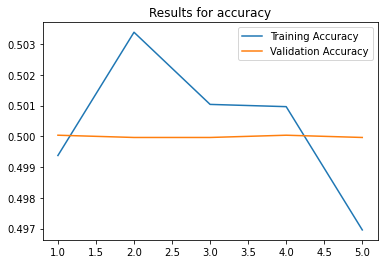

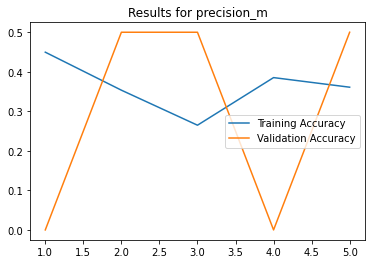

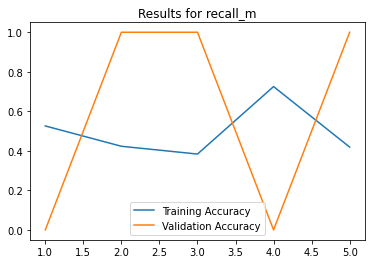

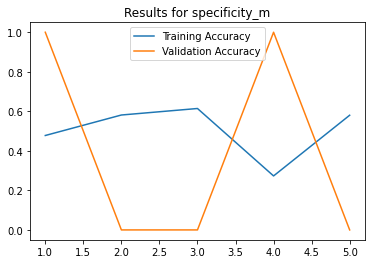

In [27]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
for i in ['accuracy', 'precision_m', 'recall_m','specificity_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()